In [1]:
from keras.models import Sequential, load_model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                          GlobalAveragePooling2D, BatchNormalization,
                          Dropout, GaussianNoise, AveragePooling2D)
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
import pickle

Using TensorFlow backend.


In [89]:
def to_onehot(idx, size):
    res = [0] * size
    res[idx] = 1
    return res


labels_fname = './labels.json'
with open(labels_fname) as f:
    fname_to_label = {
        row['fname']: to_onehot(row['label'] or 0, size=10)
        for row in list(map(json.loads, f))
    }

In [90]:
digits_dir = './digits/'

images = []
labels = []

fnames = os.listdir(digits_dir)
np.random.shuffle(fnames)
for fname in fnames:
    images.append(cv2.imread(digits_dir + fname, cv2.IMREAD_GRAYSCALE))
    labels.append(fname_to_label[fname])

print('Loaded %d digits' % len(images))

Loaded 567 digits


In [91]:
max(x.shape[0] for x in images), max(x.shape[1] for x in images)

(28, 28)

In [92]:
def preprocess_image(img):
    width, height = img.shape
    margin_x = int((28 - width) / 2)
    margin_y = int((28 - height) / 2)
    
    res = np.zeros((28, 28, 1))
    res[margin_x:margin_x+width, margin_y:margin_y+height, 0] = img
    
    res = (res - res.mean()) / res.std()
    
    return res


X_all = np.array(list(map(preprocess_image, images)))
y_all = np.array(labels)

print('Data shape: %s - Labels shape: %s' % (X_all.shape, y_all.shape))

Data shape: (567, 28, 28, 1) - Labels shape: (567, 10)


check class (im)balance

In [6]:
y_all.sum(axis=0)

array([122,  53,  45,  47,  51,  48,  45,  55,  55,  46])

only keep a random subset of no-digit images

In [7]:
mask = (y_all[:, 0] == 0) | (np.random.random(len(y_all)) < 0.4)
X_all, y_all = X_all[mask], y_all[mask]
y_all.sum(axis=0)

array([37, 53, 45, 47, 51, 48, 45, 55, 55, 46])

Use the ImageDataGenerator to synthetize training images, and show a few examples (the real images will be used as validation data)

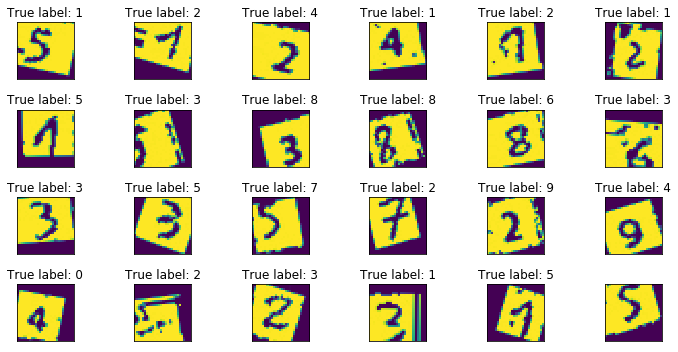

In [73]:
idg = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    #preprocessing_function=discretize,
)

idg.fit(X_all)

example = next(idg.flow(X_all, y_all, batch_size=24))
plt.figure(figsize=(10, 5))
for i, (img, label) in enumerate(zip(*example)):
    plt.title('True label: %s' % np.argmax(label))
    plt.subplot(4, 6, i + 1)
    plt.imshow(img[:, :, 0])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [83]:
l2_strength = 0.00001
conv_kwargs = {
    'kernel_regularizer': l2(l2_strength),
    'activation': 'relu',
    'padding': 'same',
}

model = Sequential([
    GaussianNoise(0.025, input_shape=X_all[0].shape),
    Conv2D(8, (3, 3), input_shape=X_all[0].shape, **conv_kwargs), BatchNormalization(),
    Conv2D(8, (3, 3), **conv_kwargs), BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(2 / 8),
    BatchNormalization(),
    Conv2D(16, (3, 3), **conv_kwargs), BatchNormalization(),
    Conv2D(16, (3, 3), **conv_kwargs), BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(4 / 16),
    BatchNormalization(),
    Conv2D(32, (3, 3), **conv_kwargs), BatchNormalization(),
    Conv2D(32, (3, 3), **conv_kwargs), BatchNormalization(),
    Dropout(16 / 32),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax', kernel_regularizer=l2(l2_strength))
])


model.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

In [84]:
hist = model.fit_generator(
    idg.flow(X_all, y_all, batch_size=8192),
    steps_per_epoch=32,
    epochs=64,
    validation_data=(X_all, y_all),
)

Epoch 1/64
32/32 [==============================] - 8s 244ms/step - loss: 2.0404 - acc: 0.2821 - val_loss: 1.8408 - val_acc: 0.2905
Epoch 2/64
32/32 [==============================] - 4s 135ms/step - loss: 1.5542 - acc: 0.5034 - val_loss: 1.2298 - val_acc: 0.5934
Epoch 3/64
32/32 [==============================] - 4s 136ms/step - loss: 1.1887 - acc: 0.6644 - val_loss: 0.9266 - val_acc: 0.7614
Epoch 4/64
32/32 [==============================] - 5s 141ms/step - loss: 0.8995 - acc: 0.7797 - val_loss: 0.7432 - val_acc: 0.8257
Epoch 5/64
32/32 [==============================] - 5s 165ms/step - loss: 0.6750 - acc: 0.8486 - val_loss: 0.6056 - val_acc: 0.8589
Epoch 6/64
32/32 [==============================] - 5s 156ms/step - loss: 0.5086 - acc: 0.8879 - val_loss: 0.4566 - val_acc: 0.9149
Epoch 7/64
32/32 [==============================] - 5s 151ms/step - loss: 0.3981 - acc: 0.9109 - val_loss: 0.3174 - val_acc: 0.9461
Epoch 8/64
32/32 [==============================] - 5s 157ms/step - loss: 0.

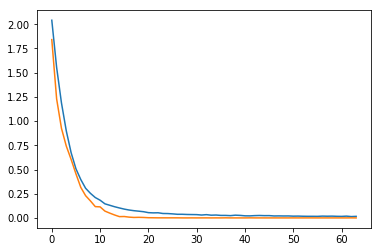

In [85]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [86]:
model.save('model.h5')

In [87]:
class DigitPredictor:
    def __init__(self, model_fname='model.h5'):
        self.model = load_model(model_fname)
    
    def predict_digits(self, images, return_proba=False):
        ''' being trained for sodoku, this does not predict zeros, and can
            tell if the image is not a digit (very first class)
        '''
        preds = self.model.predict(np.array(list(map(preprocess_image, images))))
        if return_proba:
            return preds
        else:
            preds_cls = np.argmax(preds, axis=1)
            return [c if c > 0 else None for c in preds_cls]

In [93]:
pp = DigitPredictor().predict_digits(images)